### Working with noisy data

Analytically, it's rather easy to show that the proposed content from other notebooks works. However, having an imperfect data set will suggest if gained insights are applicable to real-world data.

White gaussian noise is printed on each component. Noise is uncorrelated. Afterwards, a lowpass filter is applied to get rid off any frequency above the main signal's frequency. It remains noise in the frequency range of the signal or lower.

Some notebooks are repeated here with the clue of using noisy data. The amplitude of the noise can be modulated by changing the variable SNR_dB_u and SNR_dB_r, translational and rotational components, respectively. It is the deci-bel strength of the noise in ratio to the signal (SNR = signal to noise ratio). If strain is included, SNR_dB_s modulates it's noise.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
from scipy.signal import butter,filtfilt
from scipy.linalg import null_space

In [20]:
medium = load_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz


In [21]:
index = 1
C, density = get_specific_VTI(medium[index])
#C, density = get_random_C('triclinic',30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [22]:
def awgn(x,SNR_dB):
    L = x.size
    SNR = 10**(SNR_dB/10)                  # SNR to linear scale
    Esym = np.sum(abs(x)**2,axis=None)/(L) # calculate actual symbol energy
    N0 = Esym / SNR                        # find the noise spectral density
    noiseSigma = np.sqrt(N0)               # standard deviation for AWGN Noise
    n = noiseSigma * np.random.randn(x[:,0].size,x[0,:].size) #computed noise
    return x + n                           # received signal

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def lowpass(seis,f,fs,order=5):
    c, nt = np.shape(seis)
    seis_fil = np.zeros((c,nt))
    for i in range(0,c):
        seis_fil[i,:] = butter_lowpass_filter(seis[i,:], f, fs,order )
    return seis_fil

def make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=100.):
    c, nt = np.shape(seis)
    seis_noise = np.zeros((c,nt))
    seis_noise[0:3] = awgn(seis[0:3],SNR_dB_u)
    seis_noise[3:6] = awgn(seis[3:6],SNR_dB_r)
    if c>6:
        seis_noise[6:] = awgn(seis[6:],SNR_dB_s)
    return seis_noise

### Noisy data and low-pass filter

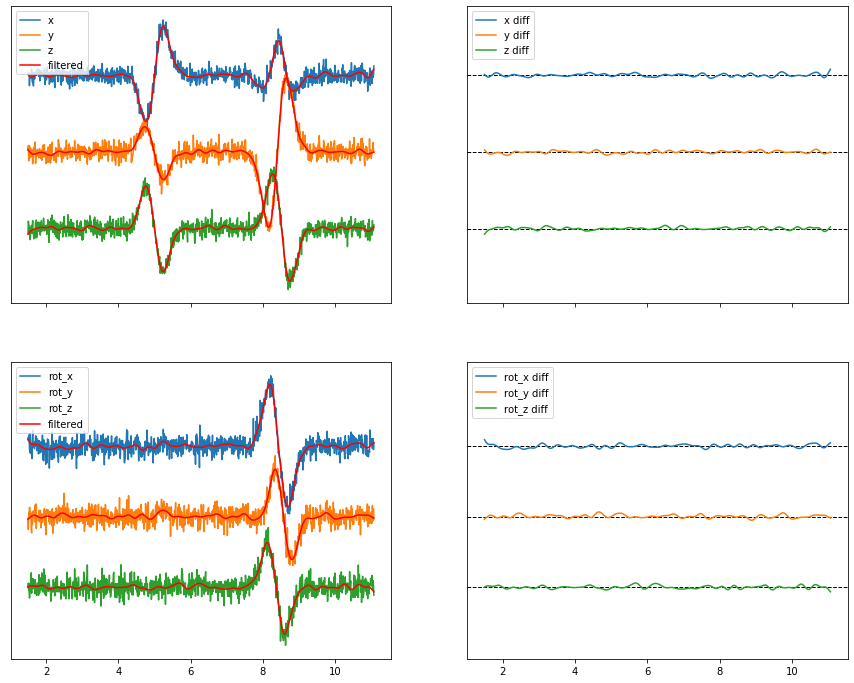

In [23]:
f = 3.
SNR_dB_u = 10.
SNR_dB_r = 5.
fs = 100.

nus, gammas = get_direction('random',C,1)
vel,v = get_eigenvals(gammas[0], density)
seis, t = get_seis(v, vel, nus[0], f, fs)
seis_noise = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
seis_fil = lowpass(seis_noise,f,fs)

# plot results
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(15,12),sharex=True,sharey='row')
a1 = abs(seis_noise[0:3][:].max())
ax[0,0].plot(t,seis_noise[0,:],label='x')
ax[0,0].plot(t,seis_noise[1,:]-a1,label='y')
ax[0,0].plot(t,seis_noise[2,:]-2*a1,label='z')
ax[0,0].plot(t,seis_fil[0,:],color='red',label='filtered')
ax[0,0].plot(t,seis_fil[1,:]-a1,color='red')
ax[0,0].plot(t,seis_fil[2,:]-2*a1,color='red')
ax[0,0].legend(loc=2)
ax[0,0].set_yticks([])
a2 = abs(seis_noise[3:][:].max())
ax[1,0].plot(t,seis_noise[3,:],label='rot_x')
ax[1,0].plot(t,seis_noise[4,:]-a2,label='rot_y')
ax[1,0].plot(t,seis_noise[5,:]-2*a2,label='rot_z')
ax[1,0].plot(t,seis_fil[3,:],color='red',label='filtered')
ax[1,0].plot(t,seis_fil[4,:]-a2,color='red')
ax[1,0].plot(t,seis_fil[5,:]-2*a2,color='red')
ax[1,0].legend(loc=2)
ax[1,0].set_yticks([])

ax[0,1].axhline(0,color='black',linestyle='dashed',lw=1)
ax[0,1].axhline(-a1,color='black',linestyle='dashed',lw=1)
ax[0,1].axhline(-2*a1,color='black',linestyle='dashed',lw=1)
ax[0,1].plot(t,seis_fil[0,:]-seis[0,:],label='x diff')
ax[0,1].plot(t,seis_fil[1,:]-seis[1,:]-a1,label='y diff')
ax[0,1].plot(t,seis_fil[2,:]-seis[2,:]-2*a1,label='z diff')
ax[0,1].legend(loc=2)
ax[0,1].set_yticks([])

ax[1,1].axhline(0,color='black',linestyle='dashed',lw=1)
ax[1,1].axhline(-a2,color='black',linestyle='dashed',lw=1)
ax[1,1].axhline(-2*a2,color='black',linestyle='dashed',lw=1)
ax[1,1].plot(t,seis_fil[3,:]-seis[3,:],label='rot_x diff')
ax[1,1].plot(t,seis_fil[4,:]-seis[4,:]-a2,label='rot_y diff')
ax[1,1].plot(t,seis_fil[5,:]-seis[5,:]-2*a2,label='rot_z diff')
ax[1,1].legend(loc=2)
ax[1,1].set_yticks([])

plt.show()


### Direction of propagation

Assuming constant propagation direction among arrivals

In [24]:
index = 1
C, density = get_specific_VTI(medium[index])
#C, density = get_random_C('triclinic',30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


#1


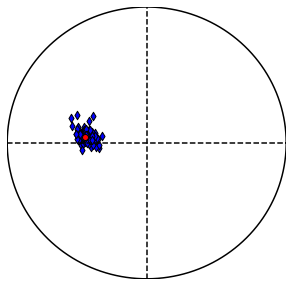

---------------------------------- 
#2


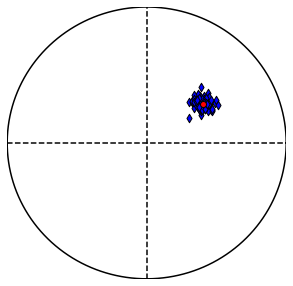

---------------------------------- 
#3


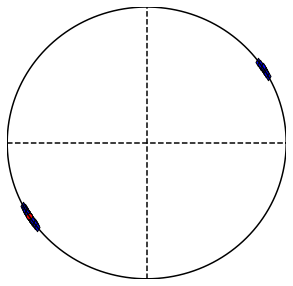

---------------------------------- 
#4


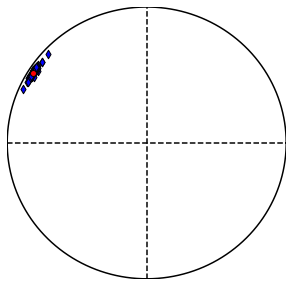

---------------------------------- 
#5


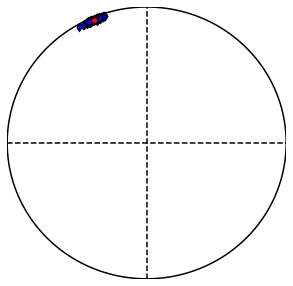

---------------------------------- 


In [25]:
f = 5.
fs = 100.
SNR_dB_u = 10.
SNR_dB_r = 5.
N = 5
Nest = 100

ang = np.linspace(0,2*np.pi,1000)
x = np.cos(ang)
y = np.sin(ang)


r2d = 180/np.pi
### generating some traces
for i in range(0,N):
    nus, gammas = get_direction('random',C,1)
    vel,v = get_eigenvals(gammas[0], density)
    theta, phi = get_angles(nus[0])
    print('#'+str(i+1))
    fig = plt.figure(figsize=(5,5))
    plt.plot(x,y,color='black')
    plt.axvline(0,color='black',ls='--')
    plt.axhline(0,color='black',ls='--')
    for j in range(0,Nest):
        seis, t = get_seis(v, vel, nus[0], f, fs)
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
        seis = lowpass(seis,f,fs)
        nu_e = get_propagation_direction(seis)
        theta_e, phi_e = get_angles(nu_e)
        plt.scatter(np.cos(phi_e)*np.sin(theta_e),np.sin(phi_e)*np.sin(theta_e),marker='d',c='b',edgecolors='black')
        
    plt.scatter(np.cos(phi)*np.sin(theta),np.sin(phi)*np.sin(theta),c='r',edgecolors='black')
    plt.xlim([-1.,1.])
    plt.ylim([-1.,1.])
    plt.yticks([])
    plt.xticks([])
    plt.axis('off')
    plt.show()
    print('---------------------------------- ')


### Propagation direction of single wavefront

#1 qP


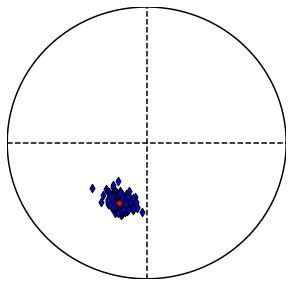

#1 qS1


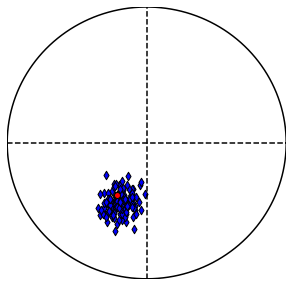

#1 qS2


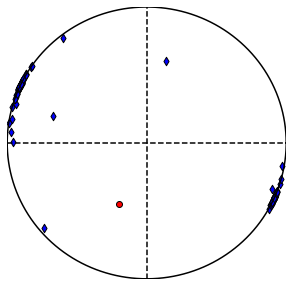

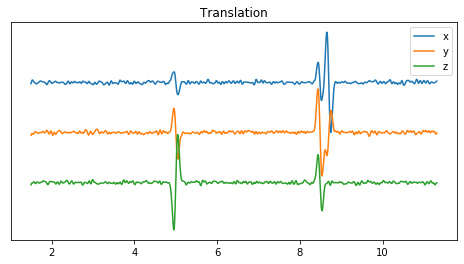

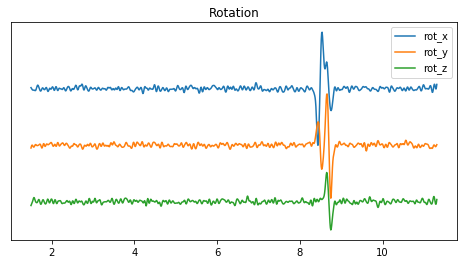

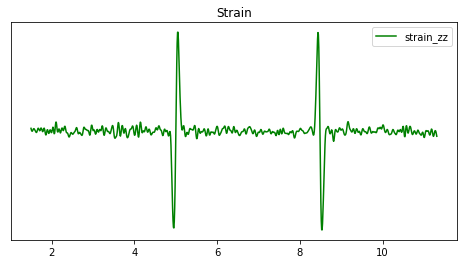

---------------------------------- 
#2 qP


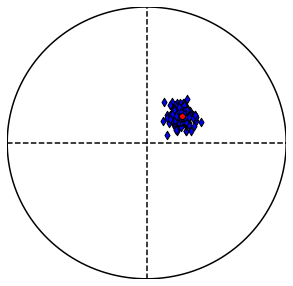

#2 qS1


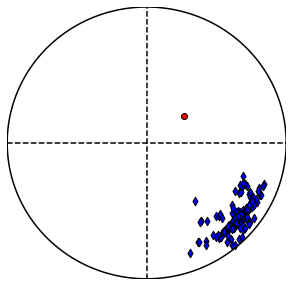

#2 qS2


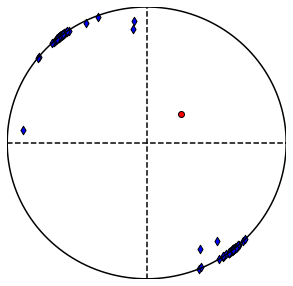

---------------------------------- 
#3 qP


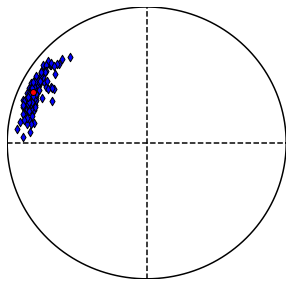

#3 qS1


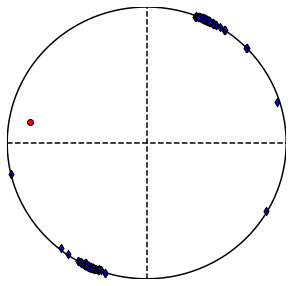

#3 qS2


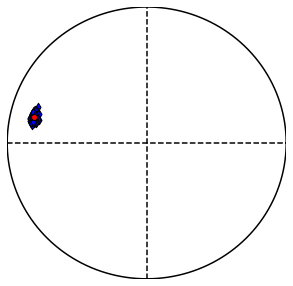

---------------------------------- 
#4 qP


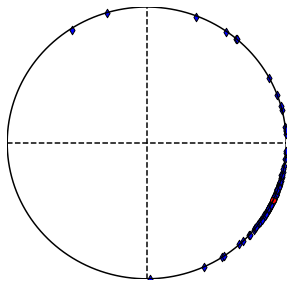

#4 qS1


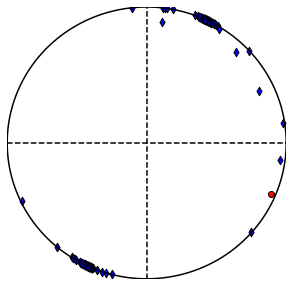

#4 qS2


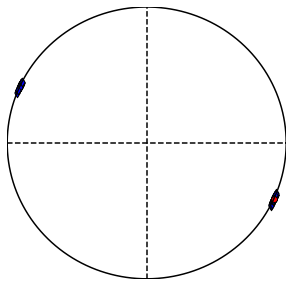

---------------------------------- 
#5 qP


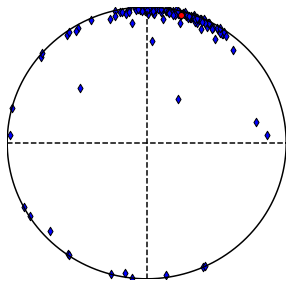

#5 qS1


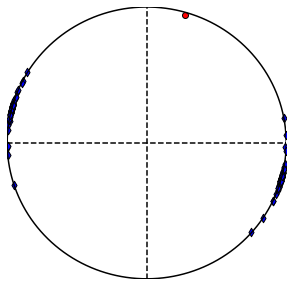

#5 qS2


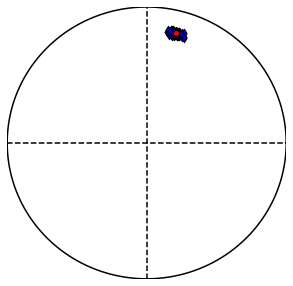

---------------------------------- 


In [26]:
f = 15.
fs = 100.
N = 5
Nest = 150
SNR_dB_u = 10.
SNR_dB_r = 5.
SNR_dB_s = 5.
alpha = 0.1
beta = 0.05

wavetype_pool = ['qP','qS1','qS2']
nus, _ = get_direction('random',C,N)
r2d = 180/np.pi
for i in range(0,len(nus)):
    nu1 = nus[i]
    theta, phi = get_angles(nus[i])
    theta_pert = theta * (1.+ alpha*np.random.randn(2))
    phi_pert = phi * (1.+beta*np.random.randn(2))
    nu2 = [np.cos(phi_pert[0])*np.sin(theta_pert[0]),\
           np.sin(phi_pert[0])*np.sin(theta_pert[0]),
           np.cos(theta_pert[0])]
    nu3 = [np.cos(phi_pert[1])*np.sin(theta_pert[1]),\
           np.sin(phi_pert[1])*np.sin(theta_pert[1]),
           np.cos(theta_pert[1])]
    props = np.array([nu1,nu2,nu3])
    gammas = get_gamma(props,C)
    vel1, v1 = get_eigenvals(gammas[0], density)
    vel2, v2 = get_eigenvals(gammas[1], density)
    vel3, v3 = get_eigenvals(gammas[2], density)
    
    l1 = np.argmax(vel1)
    vel = [vel1[l1]]
    v = [v1[:,l1]]
    dot = np.zeros(3)
    for j in range(3):
        dot[j] = abs(np.dot(v[0],v2[:,j]))
    l2 = np.argmin(dot)
    vel.append(vel2[l2])
    v.append(v2[:,l2])
                     
    dot = np.zeros(3)
    h = np.cross(v[0],v[1])                 
    for j in range(3):
        dot[j] = abs(np.dot(h,v3[:,j]))
    l3 = np.argmax(dot)       
    vel.append(vel3[l3])
    v.append(v3[:,l3])
    v = np.array(v).transpose()                 
    
    for wk in range(3):
        wavetype = wavetype_pool[wk]
        print('#'+str(i+1), wavetype)
        fig = plt.figure(figsize=(5,5))
        plt.plot(x,y,color='black')
        plt.axvline(0,color='black',ls='--')
        plt.axhline(0,color='black',ls='--')
        
        for j in range(Nest):
            #seis, t = get_seis_strain(v,vel,nus[i],f,fs)
            #seis, t = get_seis_strain_diff_propdir(v,vel,props,f,fs)
            seis, t = get_seis_strain_diff_propdir(v1,vel1,props,f,fs)
            seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=SNR_dB_s)
            seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
            seis = lowpass(seis,f,fs)

            n1,n2,n3 = get_polarizations(seis,'noise')


            ix = np.argmax(seis[0,:])
            iy = np.argmax(seis[1,:])
            iz = np.argmax(seis[2,:])
            ind = [ix,iy,iz]
            ind.sort()

            if wavetype == 'qP': 
                it = ind[0]
                n = n1
            elif wavetype =='qS1':
                it = ind[1]
                n = n2
            elif wavetype == 'qS2':
                it = ind[2]
                n = n3

            rx = seis[3,it]
            ry = seis[4,it]
            ezz = seis[6,it]

            nu_e = np.zeros(3) 
            nu_e[2] = 1.
            nu_e[1] = 2*rx/ezz + n[1]/n[2]
            nu_e[0] = -2*ry/ezz + n[0]/n[2]

            nu_e *= 1/np.sqrt(np.sum(nu_e**2))
            try:
                theta_e, phi_e = get_angles(nu_e)
                plt.scatter(np.cos(phi_e)*np.sin(theta_e),np.sin(phi_e)*np.sin(theta_e),marker='d',c='b',edgecolors='black')
            except:
                pass
        plt.scatter(props[wk,0],props[wk,1],c='r',edgecolors='black')
        plt.xlim([-1.,1.])
        plt.ylim([-1.,1.])
        plt.yticks([])
        plt.xticks([])
        plt.axis('off')
        plt.show()
        
    if i==0:
        plot_7C(seis,t)

    print('---------------------------------- ')

### Polarizations

In [27]:
index = 1
C, density = get_specific_VTI(medium[index])
#C, density = get_random_C('triclinic',30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


#1


C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:1042: RuntimeWarning: divide by zero encountered in double_scalars
  n2 *= 1/np.sqrt(np.sum(n2**2))
C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:1042: RuntimeWarning: invalid value encountered in multiply
  n2 *= 1/np.sqrt(np.sum(n2**2))


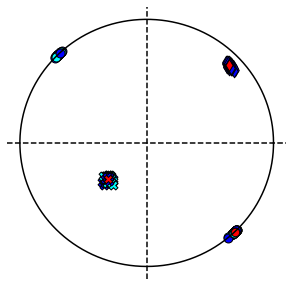

-----------------------------------
#2


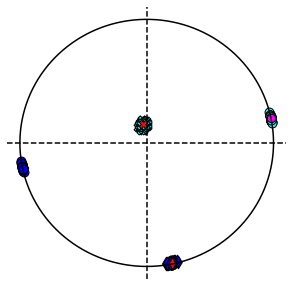

-----------------------------------
#3


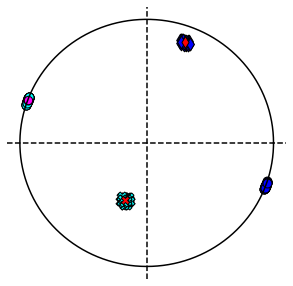

-----------------------------------
#4


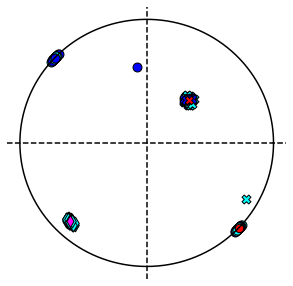

-----------------------------------
#5


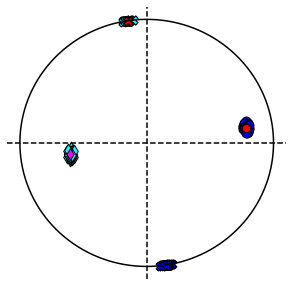

-----------------------------------


In [28]:
f = 15.
fs = 100.
SNR_dB_u = 10.
SNR_dB_r = 5.

ang = np.linspace(0,2*np.pi,1000)
x = np.cos(ang)
y = np.sin(ang)

Nest = 100
N = 5
for i in range(0,N):
    print('#'+str(i+1))
    nus, gammas = get_direction('random',C,1)
    vel,v = get_eigenvals(gammas[0], density)
    fig = plt.figure(figsize=(5,5))
    plt.plot(x,y,color='black')
    plt.axvline(0,color='black',ls='--')
    plt.axhline(0,color='black',ls='--')
    for j in range(0,Nest):
        seis, t = get_seis(v, vel, nus[0], f, fs)
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
        seis = lowpass(seis,f,fs)
        n = get_polarizations(seis,'noise')
        facecolors = ['blue','blue','blue']
        for k in range(3):
            if n[k][2]<0:
                facecolors[k] = 'cyan'
                n[k] *= -1
        plt.scatter(n[0][0],n[0][1],80,marker='d',facecolors=facecolors[0],edgecolors='black')
        plt.scatter(n[1][0],n[1][1],80,facecolors=facecolors[1],edgecolors='black')
        plt.scatter(n[2][0],n[2][1],80,marker='X',facecolors=facecolors[2],edgecolors='black')
    l1 = np.argmax(vel)
    l3 = np.argmin(vel)
    for k in range(3):
        if k!=l1 and k!=l3:
            l2 = k
    eigv = np.array([v[:,l1],v[:,l2],v[:,l3]])
    facecolors = ['red','red','red']
    for k in range(3):
        if eigv[k,2]<0:
            facecolors[k] = 'magenta'
            eigv[k] *= -1
    plt.scatter(eigv[0,0],eigv[0,1],70,marker='d',facecolors=facecolors[0],edgecolors='black')
    plt.scatter(eigv[1,0],eigv[1,1],70,facecolors=facecolors[1],edgecolors='black')
    plt.scatter(eigv[2,0],eigv[2,1],70,marker='X',facecolors=facecolors[2],edgecolors='black')
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.yticks([])
    plt.xticks([])
    plt.axis('off')
    plt.show()
    print('-----------------------------------')

### Velocity estimation

In [29]:
#C, density = get_random_C('orthorhombic',30)
C, density = get_specific_VTI(medium[1])

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


#1
Propagation direction (x|y|z)
[-0.5069102   0.84497589  0.17046347]
Expected value difference: 
qP:    348.79
qP 7C: 348.79
qS1:   21.71
qS2:   14.61
Standard deviation: 
qP:    1239.51
qP 7C: 1239.51
qS1:   60.87
qS2:   47.14


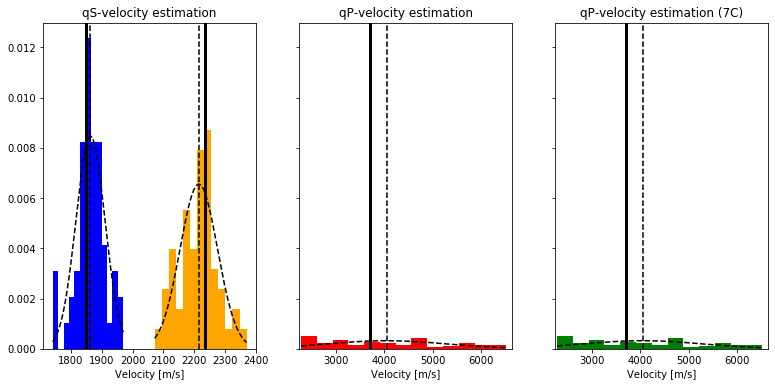

------------------------------------------
#2
Propagation direction (x|y|z)
[0.01224536 0.97440386 0.22447085]
Expected value difference: 
qP:    184.53
qP 7C: 238.23
qS1:   6.46
qS2:   7.89
Standard deviation: 
qP:    1215.66
qP 7C: 1225.22
qS1:   88.24
qS2:   48.74


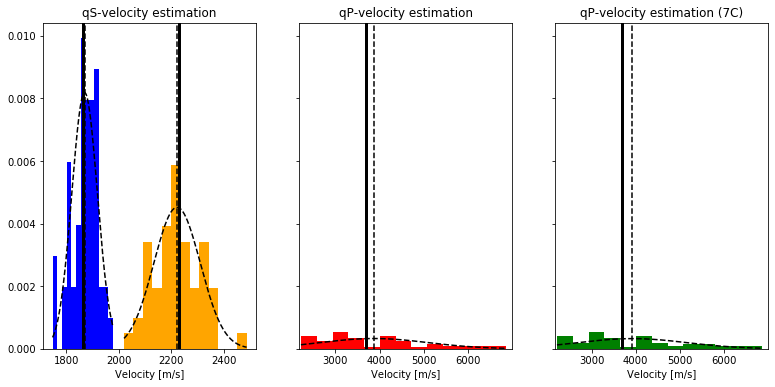

------------------------------------------
#3
Propagation direction (x|y|z)
[-0.08638254 -0.54539787  0.83371411]
Expected value difference: 
qP:    337.77
qP 7C: 51.63
qS1:   0.62
qS2:   22.34
Standard deviation: 
qP:    1117.31
qP 7C: 187.43
qS1:   56.88
qS2:   47.99


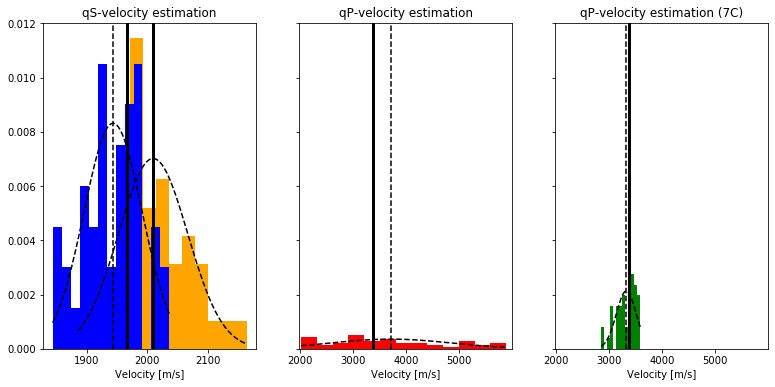

------------------------------------------


In [30]:
f = 15.
fs = 100.
SNR_dB_u = 10.
SNR_dB_r = 5.
SNR_dB_s = 5.
N = 3
Nest = 100
min_vertical = 75.

Nplot = 1000

nus, gammas = get_direction('random',C,N+2)
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    x = []
    x2 = []
    y = []
    z = []
    mu = np.zeros(4)
    sig = np.zeros(4)
    for j in range(0,Nest):
        seis, t = get_seis_strain(v,vel,nus[i],f,fs)
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=SNR_dB_s)
        seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
        seis = lowpass(seis,f,fs)
        
        n_trans = get_polarizations(seis,'noise')
        nu_e = get_propagation_direction(seis)
        vel_e,_,_ = estimate_velocity(seis,nu_e,t)
        vel_e2,_,_ = estimate_velocity_7C(seis,nu_e,t,min_vertical)
        if vel_e[0]==0. or vel_e[0]/3 > vel_e[1] or vel_e[0]<vel_e[1] :
            pass
        elif vel_e2[0]==0. or vel_e2[0]/3 > vel_e[1] or vel_e2[0]<vel_e[1] :
            pass
        else:
            x.append(vel_e[0])
            x2.append(vel_e2[0])
            y.append(vel_e[1])
            z.append(vel_e[2])
    ### maximum-likelihood for gaussian distribution
    # expected mean
    n = len(x)
    mu[0] = 1/n * np.sum(x)
    mu[1] = 1/n * np.sum(x2)
    mu[2] = 1/n * np.sum(y)
    mu[3] = 1/n * np.sum(z)
    # exptected variance
    sig[0] = 1/n * np.sum((x-mu[0])**2)
    sig[1] = 1/n * np.sum((x2-mu[1])**2)
    sig[2] = 1/n * np.sum((y-mu[2])**2)
    sig[3] = 1/n * np.sum((z-mu[3])**2)
    
    xx = np.linspace(min(x),max(x),Nplot)
    xy = 1/np.sqrt(2*np.pi*sig[0])*np.e**(-1/(2*sig[0])*(xx-mu[0])**2)
    x2x = np.linspace(min(x2),max(x2),Nplot)
    x2y = 1/np.sqrt(2*np.pi*sig[1])*np.e**(-1/(2*sig[1])*(x2x-mu[1])**2)
    yx = np.linspace(min(y),max(y),Nplot)
    yy = 1/np.sqrt(2*np.pi*sig[2])*np.e**(-1/(2*sig[2])*(yx-mu[2])**2)
    zx = np.linspace(min(z),max(z),Nplot)
    zy = 1/np.sqrt(2*np.pi*sig[3])*np.e**(-1/(2*sig[3])*(zx-mu[3])**2)
    
    print('#'+str(i))
    print('Propagation direction (x|y|z)')
    print(nus[i])
    print('Expected value difference: ')
    print('qP:    '+str(round(abs(mu[0]-max(vel)),2)))
    print('qP 7C: '+str(round(abs(mu[1]-max(vel)),2)))
    print('qS1:   '+str(round(abs(mu[2]-np.median(vel)),2)))
    print('qS2:   '+str(round(abs(mu[3]-min(vel)),2)))
    
    print('Standard deviation: ')
    print('qP:    '+str(round(np.sqrt(sig[0]),2)))
    print('qP 7C: '+str(round(np.sqrt(sig[1]),2)))
    print('qS1:   '+str(round(np.sqrt(sig[2]),2)))
    print('qS2:   '+str(round(np.sqrt(sig[3]),2)))
    
    
    fig, [ax3,ax1,ax2] = plt.subplots(ncols=3, figsize=(13,6),sharey='row') 
    
    ax1.set_title('qP-velocity estimation')
    ax1.hist(x,bins=13,color='red',density=True)
    ax1.plot(xx,xy,color='black',linestyle='dashed')
    ax1.axvline(max(vel),linewidth=3,linestyle='solid',c='black')
    ax1.axvline(mu[0],linestyle='dashed',c='black')
    ax1.set_xlim([min(x)*0.98,max(x)*1.02])
    ax1.set_xlabel('Velocity [m/s]')
    
    ax2.set_title('qP-velocity estimation (7C)')
    ax2.hist(x2,bins=13,color='green',density=True)
    ax2.axvline(max(vel),linewidth=3,linestyle='solid',c='black')
    ax2.axvline(mu[1],linestyle='dashed',c='black')
    ax2.plot(x2x,x2y,color='black',linestyle='dashed')
    ax2.set_xlim([min(x)*0.98,max(x)*1.02])
    ax2.set_xlabel('Velocity [m/s]')
    
    ax3.set_title('qS-velocity estimation')
    ax3.hist(y,bins=13,color='orange',density=True)
    ax3.hist(z,bins=13,color='blue',density=True)
    ax3.axvline(min(vel),linewidth=3,linestyle='solid',c='black')
    ax3.axvline(np.median(vel),linewidth=3,linestyle='solid',c='black')
    ax3.axvline(mu[2],linestyle='dashed',c='black')
    ax3.axvline(mu[3],linestyle='dashed',c='black')
    ax3.plot(yx,yy,color='black',linestyle='dashed')
    ax3.plot(zx,zy,color='black',linestyle='dashed')
    ax3.set_xlabel('Velocity [m/s]')
    plt.show()
    print('------------------------------------------')  

In [31]:
#C, density = get_random_C('orthorhombic',30)
C, density = get_specific_VTI(medium[1])

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


Error in get_angles().
1 failed events.
2 estimates stripped


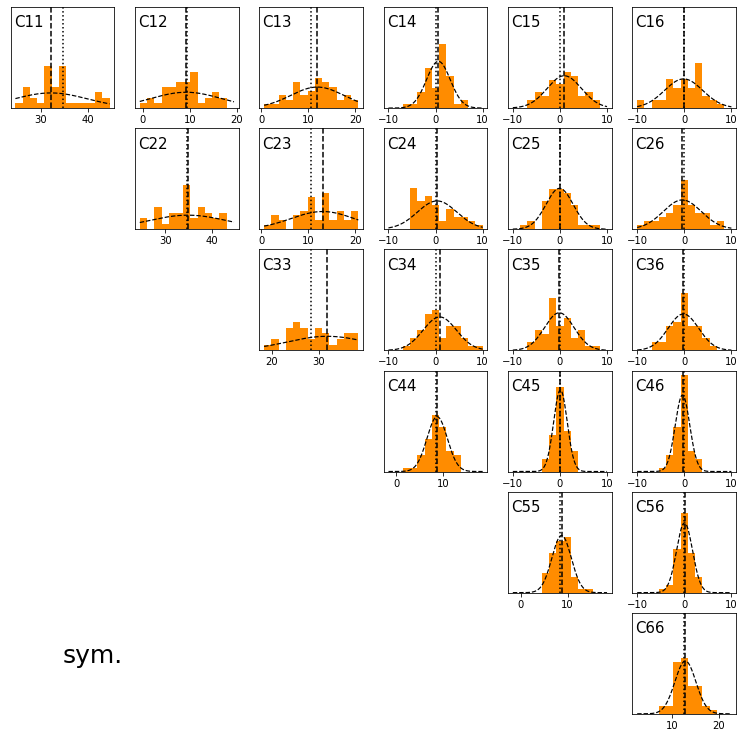

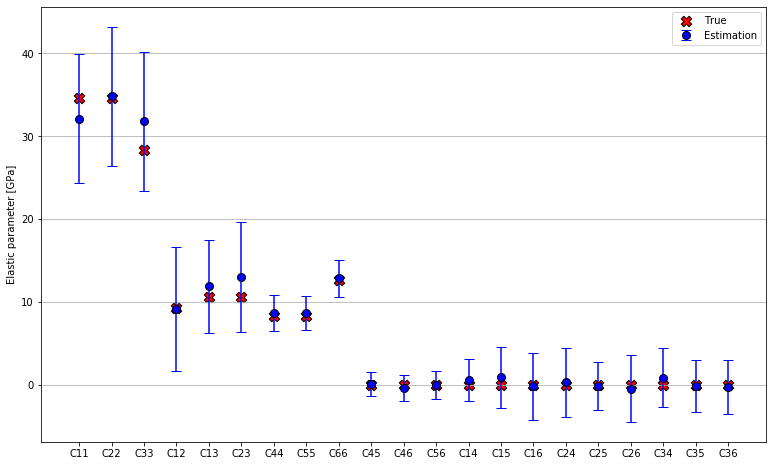

In [32]:
f = 15.
fs = 100.
SNR_dB_u = 10.
SNR_dB_r = 5.
N = 40 # shots per inversion
Ninv = 50  # repetition of inversion
mode = 'triclinic'
ang1 = 0.
ang2 = 0.
ang3 = 0.

errorcounter = 0
C_e = np.zeros((Ninv,6,6))
nu_used = []
misfit = np.zeros(Ninv)

C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

for j in range(0,Ninv):
    nus, gammas = get_direction('random',C,N)
    d = np.array([])
    G = np.array([])
    for i in range(0,N):
        vel, v = get_eigenvals(gammas[i], density)
        seis, t = get_seis(v,vel,nus[i],f,fs) 
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
        seis = lowpass(seis,f,fs)
        try: #every thousandth direction there's one that fails for some reason
            n_trans = get_polarizations(seis,'noise') 
            nu_e = get_propagation_direction(seis)
            vel_e,_,_ = estimate_velocity(seis,nu_e,t)
            if vel_e[0]==0. or vel_e[0]/3 >vel_e[1]:# or vel_e[0]<vel_e[1]:
                pass
            else:
                nu_used.append(nu_e)
                d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
        except:
            errorcounter += 1

    Q = np.linalg.inv(np.dot(G.transpose(),G))         
    m = np.dot(np.dot(Q,G.transpose()),d)
    C_e[j,:,:] = sort_elastic_coeff(mode,m)  
    eps = d - np.dot(G,m)
    misfit[j] = np.sqrt(np.dot(eps,eps))/len(nu_used)*1e-9
    
C = rotate_C(C,3,-ang3)
C = rotate_C(C,2,-ang2)
C = rotate_C(C,1,-ang1)

for i in range(0,np.shape(C_e)[0]):
    C_e[i,:,:] = rotate_C(C_e[i,:,:],3,-ang3)
    C_e[i,:,:] = rotate_C(C_e[i,:,:],2,-ang2)
    C_e[i,:,:] = rotate_C(C_e[i,:,:],1,-ang1)

print(str(errorcounter)+' failed events.')    
triangularplot(C,C_e,13,10,Ninv,False,savename='example')

### Inversion

### 6C inversion - error evaluation

There are three sources of errors. First, the estimation of the propagation direction $\nu$. Second, the estimation of the three polarizations $n$ and lastly the velocity estimations of pressure and shear waves.

The estimations:

    1) no analytical results
    2) accurate propagation direction
    3) accurate polarizations
    4) accurate propagation direction & polarizations
    5) accurate qS velocities
    6) accurate qP velocity
    7) accurate qP & qS velocities
    8) accurate velocities and prop. direction
    9) accurate qS & prop. direction & polarizations
    10) exact solution

In [33]:
C, density = get_specific_VTI(medium[1])
#C, density = get_random_C('triclinic',20)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [34]:
ang1 = 0
ang2 = 0
ang3 = 0
C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

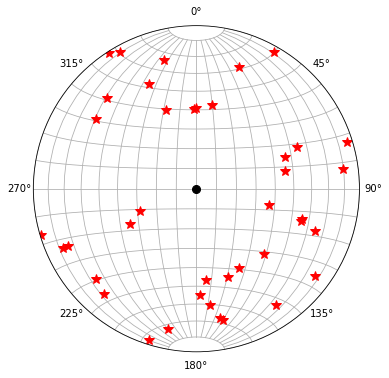

Used Events: 
 1) 0.8
 2) 0.9
 3) 0.8
 4) 0.9
 5) 0.8
 6) 1.0
 7) 1.0
 8) 1.0
 9) 0.925
10) 1.0
 
Misfit:
 1) 4.13063199266752
 2) 3.1117238122731665
 3) 4.217755797352279
 4) 3.114162068383166
 5) 4.07404391080569
 6) 0.8543028288369369
 7) 0.7028559362626486
 8) 0.09920335248715177
 9) 3.574786416874512
10) 5.345750891283198e-14


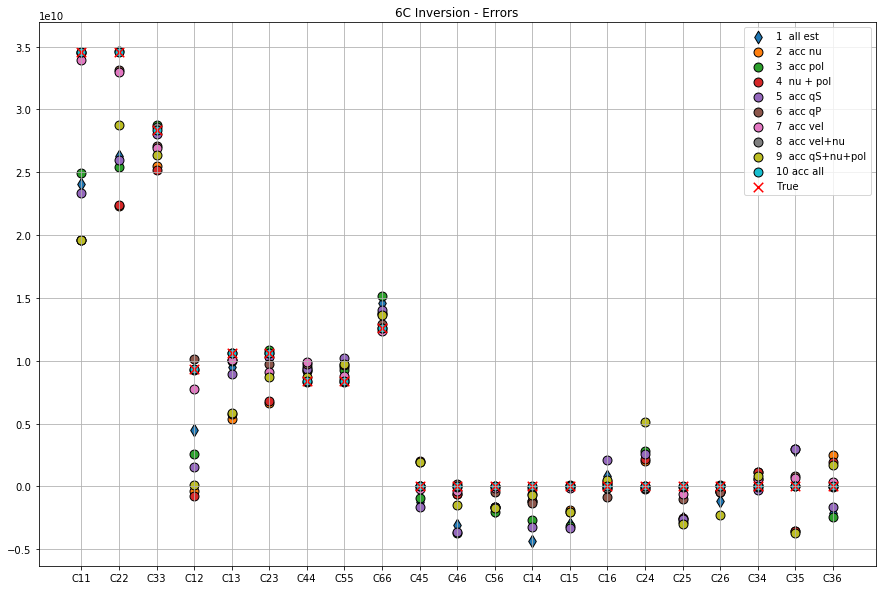

In [35]:
f = 10.
fs = 100.
SNR_dB_u = 10.
SNR_dB_r = 5.
N = 40

## mode: assumed symmetry
mode = 'triclinic'

d1 = np.array([])
d2 = np.array([])
d3 = np.array([])
d4 = np.array([])
d5 = np.array([])
d6 = np.array([])
d7 = np.array([])
d8 = np.array([])
d9 = np.array([])
da = np.array([])

G1 = np.array([])
G2 = np.array([])
G3 = np.array([])
G4 = np.array([])
G5 = np.array([])
G6 = np.array([])
G7 = np.array([])
G8 = np.array([])
G9 = np.array([])
Ga = np.array([])

C_e1 = np.zeros((6,6))
C_e2 = np.zeros((6,6))
C_e3 = np.zeros((6,6))
C_e4 = np.zeros((6,6))
C_e5 = np.zeros((6,6))
C_e6 = np.zeros((6,6))
C_e7 = np.zeros((6,6))
C_e8 = np.zeros((6,6))
C_e9 = np.zeros((6,6))
C_ea = np.zeros((6,6))

nu_used1 = []
nu_used2 = []
nu_used3 = []
nu_used4 = []
nu_used5 = []
nu_used6 = []
nu_used7 = []
nu_used8 = []
nu_used9 = []
nu_useda = []

nus, gammas = get_direction('random',C,N+2,theta_e=0.,phi_e=0.)
plot_directions(nus[1:N+1])

all_seis = []
all_t = []
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_strain(v,vel,nus[i],f,fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
    seis = lowpass(seis,f,fs)
    all_seis.append(seis)
    all_t.append(t)
    
    iqP = np.argmax(vel)
    iqS2 = np.argmin(vel)
    for l in range(0,3):
        if iqP!=l and iqS2!=l:
            iqS1 = l
    
    #1) no analytical results
    n_trans = get_polarizations(seis,'noise')
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_used1.append(nu_e)
        d1,G1 = add_new_data(mode,d1,G1,nu_e,vel_e,n_trans,density)
        
    #2) accurate propagation direction        
    n_trans = get_polarizations(seis,'noise')
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_used2.append(nu_e)
        d2,G2 = add_new_data(mode,d2,G2,nu_e,vel_e,n_trans,density)
    
    #3) accurate polarizations

    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_used3.append(nu_e)
        d3,G3 = add_new_data(mode,d3,G3,nu_e,vel_e,n_trans,density)
        
    #4) accurate propagation direction & polarizations
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_used4.append(nu_e)
        d4,G4 = add_new_data(mode,d4,G4,nu_e,vel_e,n_trans,density)
        
    #5) accurate qS velocities
    
    n_trans = get_polarizations(seis,'noise')
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_used5.append(nu_e)
        d5,G5 = add_new_data(mode,d5,G5,nu_e,vel_e,n_trans,density)
    
    #6) accurate qP velocity
    
    n_trans = get_polarizations(seis,'noise')
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    vel_e[0] = vel[iqP]
    
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_used6.append(nu_e)
        d6,G6 = add_new_data(mode,d6,G6,nu_e,vel_e,n_trans,density)
        
    #7) accurate qP & qS velocities 
    
    n_trans = get_polarizations(seis,'noise')
    nu_e = get_propagation_direction(seis)
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_used7.append(nu_e)
        d7,G7 = add_new_data(mode,d7,G7,nu_e,vel_e,n_trans,density)
        
    #10) Accurate Solution
    
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_used8.append(nu_e)
        d8,G8 = add_new_data(mode,d8,G8,nu_e,vel_e,n_trans,density)
    
    #8) accurate velocities and prop. direction
    
    n_trans = get_polarizations(seis,'noise')
    nu_e = nus[i]
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_used9.append(nu_e)
        d9,G9 = add_new_data(mode,d9,G9,nu_e,vel_e,n_trans,density)
        
    #9) Accurate qS & prop. direction & polarizations
    
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    if vel_e[0]==0. or vel_e[0]/3 > vel_e[1]: #or vel_e[0]<vel_e[1] :
        pass
    else:
        nu_useda.append(nu_e)
        da,Ga = add_new_data(mode,da,Ga,nu_e,vel_e,n_trans,density)
    
    
    

Q1 = np.linalg.inv(np.dot(G1.transpose(),G1))         
m1 = np.dot(np.dot(Q1,G1.transpose()),d1)
C_e1 = sort_elastic_coeff(mode,m1)  
eps1 = d1 - np.dot(G1,m1) 

Q2 = np.linalg.inv(np.dot(G2.transpose(),G2))         
m2 = np.dot(np.dot(Q2,G2.transpose()),d2)
C_e2 = sort_elastic_coeff(mode,m2)  
eps2 = d2 - np.dot(G2,m2)

Q3 = np.linalg.inv(np.dot(G3.transpose(),G3))         
m3 = np.dot(np.dot(Q3,G3.transpose()),d3)
C_e3 = sort_elastic_coeff(mode,m3)  
eps3 = d3 - np.dot(G3,m3)

Q4 = np.linalg.inv(np.dot(G4.transpose(),G4))         
m4 = np.dot(np.dot(Q4,G4.transpose()),d4)
C_e4 = sort_elastic_coeff(mode,m4)  
eps4 = d4 - np.dot(G4,m4)

Q5 = np.linalg.inv(np.dot(G5.transpose(),G5))         
m5 = np.dot(np.dot(Q5,G5.transpose()),d5)
C_e5 = sort_elastic_coeff(mode,m5)  
eps5 = d5 - np.dot(G5,m5)

Q6 = np.linalg.inv(np.dot(G6.transpose(),G6))         
m6 = np.dot(np.dot(Q6,G6.transpose()),d6)
C_e6 = sort_elastic_coeff(mode,m6)  
eps6 = d6 - np.dot(G6,m6)

Q7 = np.linalg.inv(np.dot(G7.transpose(),G7))         
m7 = np.dot(np.dot(Q7,G7.transpose()),d7)
C_e7 = sort_elastic_coeff(mode,m7)  
eps7 = d7 - np.dot(G7,m7)

Q8 = np.linalg.inv(np.dot(G8.transpose(),G8))         
m8 = np.dot(np.dot(Q8,G8.transpose()),d8)
C_e8 = sort_elastic_coeff(mode,m8)  
eps8 = d8 - np.dot(G8,m8)

Q9 = np.linalg.inv(np.dot(G9.transpose(),G9))         
m9 = np.dot(np.dot(Q9,G9.transpose()),d9)
C_e9 = sort_elastic_coeff(mode,m9)  
eps9 = d9 - np.dot(G9,m9)

Qa = np.linalg.inv(np.dot(Ga.transpose(),Ga))         
ma = np.dot(np.dot(Qa,Ga.transpose()),da)
C_ea = sort_elastic_coeff(mode,ma)  
epsa = da - np.dot(Ga,ma) 
    
C = rotate_C(C,3,-ang3)
C = rotate_C(C,2,-ang2)
C = rotate_C(C,1,-ang1)

C_e1 = rotate_C(C_e1,3,-ang3)
C_e1 = rotate_C(C_e1,2,-ang2)
C_e1 = rotate_C(C_e1,1,-ang1)

C_e2 = rotate_C(C_e2,3,-ang3)
C_e2 = rotate_C(C_e2,2,-ang2)
C_e2 = rotate_C(C_e2,1,-ang1)

C_e3 = rotate_C(C_e3,3,-ang3)
C_e3 = rotate_C(C_e3,2,-ang2)
C_e3 = rotate_C(C_e3,1,-ang1)

C_e4 = rotate_C(C_e4,3,-ang3)
C_e4 = rotate_C(C_e4,2,-ang2)
C_e4 = rotate_C(C_e4,1,-ang1)

C_e5 = rotate_C(C_e5,3,-ang3)
C_e5 = rotate_C(C_e5,2,-ang2)
C_e5 = rotate_C(C_e5,1,-ang1)

C_e6 = rotate_C(C_e6,3,-ang3)
C_e6 = rotate_C(C_e6,2,-ang2)
C_e6 = rotate_C(C_e6,1,-ang1)

C_e7 = rotate_C(C_e7,3,-ang3)
C_e7 = rotate_C(C_e7,2,-ang2)
C_e7 = rotate_C(C_e7,1,-ang1)

C_e8 = rotate_C(C_e8,3,-ang3)
C_e8 = rotate_C(C_e8,2,-ang2)
C_e8 = rotate_C(C_e8,1,-ang1)

C_e9 = rotate_C(C_e9,3,-ang3)
C_e9 = rotate_C(C_e9,2,-ang2)
C_e9 = rotate_C(C_e9,1,-ang1)

C_ea = rotate_C(C_ea,3,-ang3)
C_ea = rotate_C(C_ea,2,-ang2)
C_ea = rotate_C(C_ea,1,-ang1)

print('Used Events: ')
print(' 1) '+str(len(nu_used1)/N))
print(' 2) '+str(len(nu_used2)/N))
print(' 3) '+str(len(nu_used3)/N))
print(' 4) '+str(len(nu_used4)/N))
print(' 5) '+str(len(nu_used5)/N))
print(' 6) '+str(len(nu_used6)/N))
print(' 7) '+str(len(nu_used7)/N))
print(' 8) '+str(len(nu_used9)/N))
print(' 9) '+str(len(nu_useda)/N))
print('10) '+str(len(nu_used8)/N))
print(' ')
    
print('Misfit:')
print(' 1) '+str(np.sqrt(np.dot(eps1,eps1))*1e-9/len(nu_used1)))
print(' 2) '+str(np.sqrt(np.dot(eps2,eps2))*1e-9/len(nu_used2)))
print(' 3) '+str(np.sqrt(np.dot(eps3,eps3))*1e-9/len(nu_used3)))
print(' 4) '+str(np.sqrt(np.dot(eps4,eps4))*1e-9/len(nu_used4)))
print(' 5) '+str(np.sqrt(np.dot(eps5,eps5))*1e-9/len(nu_used5)))
print(' 6) '+str(np.sqrt(np.dot(eps6,eps6))*1e-9/len(nu_used6)))
print(' 7) '+str(np.sqrt(np.dot(eps7,eps7))*1e-9/len(nu_used7)))
print(' 8) '+str(np.sqrt(np.dot(eps9,eps9))*1e-9/len(nu_used9)))
print(' 9) '+str(np.sqrt(np.dot(epsa,epsa))*1e-9/len(nu_useda)))
print('10) '+str(np.sqrt(np.dot(eps8,eps8))*1e-9/len(nu_used8)))


param = ['C11','C22','C33','C12','C13','C23','C44','C55','C66','C45','C46','C56','C14','C15','C16','C24',\
         'C25','C26','C34','C35','C36']
c_true = [C[0,0],C[1,1],C[2,2],C[0,1],C[0,2],C[1,2],C[3,3],C[4,4],C[5,5],C[3,4],C[3,5],C[4,5],C[0,3],C[0,4],\
          C[0,5],C[1,3],C[1,4],C[1,5],C[2,3],C[2,4],C[2,5]]
c_est1 = [C_e1[0,0],C_e1[1,1],C_e1[2,2],C_e1[0,1],C_e1[0,2],C_e1[1,2],C_e1[3,3],C_e1[4,4],C_e1[5,5],C_e1[3,4],\
         C_e1[3,5],C_e1[4,5],C_e1[0,3],C_e1[0,4],C_e1[0,5],C_e1[1,3],C_e1[1,4],C_e1[1,5],C_e1[2,3],C_e1[2,4],\
         C_e1[2,5]]
c_est2 = [C_e2[0,0],C_e2[1,1],C_e2[2,2],C_e2[0,1],C_e2[0,2],C_e2[1,2],C_e2[3,3],C_e2[4,4],C_e2[5,5],C_e2[3,4],\
          C_e2[3,5],C_e2[4,5],C_e2[0,3],C_e2[0,4],C_e2[0,5],C_e2[1,3],C_e2[1,4],C_e2[1,5],C_e2[2,3],C_e2[2,4],\
          C_e2[2,5]]
c_est3 = [C_e3[0,0],C_e3[1,1],C_e3[2,2],C_e3[0,1],C_e3[0,2],C_e3[1,2],C_e3[3,3],C_e3[4,4],C_e3[5,5],C_e3[3,4],\
          C_e3[3,5],C_e3[4,5],C_e3[0,3],C_e3[0,4],C_e3[0,5],C_e3[1,3],C_e3[1,4],C_e3[1,5],C_e3[2,3],C_e3[2,4],\
          C_e3[2,5]]
c_est4 = [C_e4[0,0],C_e4[1,1],C_e4[2,2],C_e4[0,1],C_e4[0,2],C_e4[1,2],C_e4[3,3],C_e4[4,4],C_e4[5,5],C_e4[3,4],\
          C_e4[3,5],C_e4[4,5],C_e4[0,3],C_e4[0,4],C_e4[0,5],C_e4[1,3],C_e4[1,4],C_e4[1,5],C_e4[2,3],C_e4[2,4],\
          C_e4[2,5]]
c_est5 = [C_e5[0,0],C_e5[1,1],C_e5[2,2],C_e5[0,1],C_e5[0,2],C_e5[1,2],C_e5[3,3],C_e5[4,4],C_e5[5,5],C_e5[3,4],\
          C_e5[3,5],C_e5[4,5],C_e5[0,3],C_e5[0,4],C_e5[0,5],C_e5[1,3],C_e5[1,4],C_e5[1,5],C_e5[2,3],C_e5[2,4],\
          C_e5[2,5]]
c_est6 = [C_e6[0,0],C_e6[1,1],C_e6[2,2],C_e6[0,1],C_e6[0,2],C_e6[1,2],C_e6[3,3],C_e6[4,4],C_e6[5,5],C_e6[3,4],\
          C_e6[3,5],C_e6[4,5],C_e6[0,3],C_e6[0,4],C_e6[0,5],C_e6[1,3],C_e6[1,4],C_e6[1,5],C_e6[2,3],C_e6[2,4],\
          C_e6[2,5]]
c_est7 = [C_e7[0,0],C_e7[1,1],C_e7[2,2],C_e7[0,1],C_e7[0,2],C_e7[1,2],C_e7[3,3],C_e7[4,4],C_e7[5,5],C_e7[3,4],\
          C_e7[3,5],C_e7[4,5],C_e7[0,3],C_e7[0,4],C_e7[0,5],C_e7[1,3],C_e7[1,4],C_e7[1,5],C_e7[2,3],C_e7[2,4],\
          C_e7[2,5]]
c_est8 = [C_e8[0,0],C_e8[1,1],C_e8[2,2],C_e8[0,1],C_e8[0,2],C_e8[1,2],C_e8[3,3],C_e8[4,4],C_e8[5,5],C_e8[3,4],\
          C_e8[3,5],C_e8[4,5],C_e8[0,3],C_e8[0,4],C_e8[0,5],C_e8[1,3],C_e8[1,4],C_e8[1,5],C_e8[2,3],C_e8[2,4],\
          C_e8[2,5]]

c_est9 = [C_e9[0,0],C_e9[1,1],C_e9[2,2],C_e9[0,1],C_e9[0,2],C_e9[1,2],C_e9[3,3],C_e9[4,4],C_e9[5,5],C_e9[3,4],\
          C_e9[3,5],C_e9[4,5],C_e9[0,3],C_e9[0,4],C_e9[0,5],C_e9[1,3],C_e9[1,4],C_e9[1,5],C_e9[2,3],C_e9[2,4],\
          C_e9[2,5]]

c_esta = [C_ea[0,0],C_ea[1,1],C_ea[2,2],C_ea[0,1],C_ea[0,2],C_ea[1,2],C_ea[3,3],C_ea[4,4],C_ea[5,5],C_ea[3,4],\
          C_ea[3,5],C_ea[4,5],C_ea[0,3],C_ea[0,4],C_ea[0,5],C_ea[1,3],C_ea[1,4],C_ea[1,5],C_ea[2,3],C_ea[2,4],\
          C_ea[2,5]]

plt.figure(figsize=(15,10))
plt.title('6C Inversion - Errors')
plt.scatter(param,c_est1,label='1  all est',marker='d',s=80,edgecolors='black')
plt.scatter(param,c_est2,label='2  acc nu',s=80,edgecolors='black')
plt.scatter(param,c_est3,label='3  acc pol',s=80,edgecolors='black')
plt.scatter(param,c_est4,label='4  nu + pol',s=80,edgecolors='black')
plt.scatter(param,c_est5,label='5  acc qS',s=80,edgecolors='black')
plt.scatter(param,c_est6,label='6  acc qP',s=80,edgecolors='black')
plt.scatter(param,c_est7,label='7  acc vel',s=80,edgecolors='black')
plt.scatter(param,c_est9,label='8  acc vel+nu',s=80,edgecolors='black')
plt.scatter(param,c_esta,label='9  acc qS+nu+pol',s=80,edgecolors='black')
plt.scatter(param,c_est8,label='10 acc all',s=80,edgecolors='black')
plt.scatter(param,c_true,color='red',marker='x',label='True',s=90,edgecolors='black')
plt.grid()
plt.legend(loc=1)
plt.show()

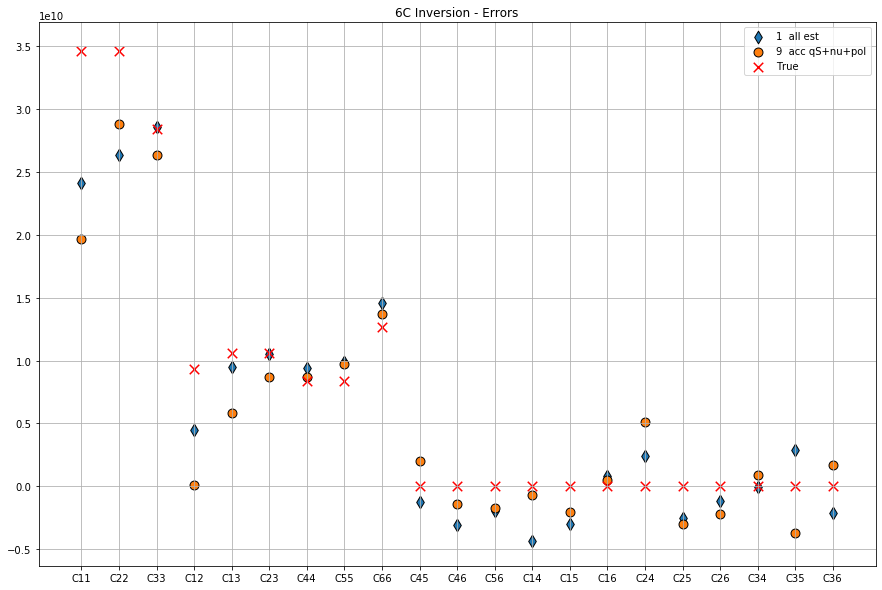

In [36]:
plt.figure(figsize=(15,10))
plt.title('6C Inversion - Errors')
plt.scatter(param,c_est1,label='1  all est',marker='d',s=80,edgecolors='black')
#plt.scatter(param,c_est2,label='2  acc nu',s=80,edgecolors='black')
#plt.scatter(param,c_est3,label='3  acc pol',s=80,edgecolors='black')
#plt.scatter(param,c_est4,label='4  nu + pol',s=80,edgecolors='black')
#plt.scatter(param,c_est5,label='5  acc qS',s=80,edgecolors='black')
#plt.scatter(param,c_est6,label='6  acc qP',s=80,edgecolors='black')
#plt.scatter(param,c_est7,label='7  acc vel',s=80,edgecolors='black')
#plt.scatter(param,c_est9,label='8  acc vel+nu',s=80,edgecolors='black')
plt.scatter(param,c_esta,label='9  acc qS+nu+pol',s=80,edgecolors='black')
#plt.scatter(param,c_est8,label='10 acc all',s=80,edgecolors='black')
plt.scatter(param,c_true,color='red',marker='x',label='True',s=90,edgecolors='black')
plt.grid()
plt.legend(loc=1)
plt.show()